In [1]:
import nengo
import nengo_spa as spa
import numpy as np
from random import shuffle
import random


use_ocl = True
if use_ocl:
    import nengo_ocl
    simulator = nengo_ocl.Simulator
else:
    simulator = nengo.Simulator
    
import sys, os

sys.path.append('..')
import experiments as xps

import math
import matplotlib.pyplot as plt
from cycler import cycler
%matplotlib inline
default_cycler = cycler('color', ['#006BA4', '#FF800E', '#ABABAB', '#595959', '#5F9ED1', '#C85200', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF'])
plt.rc('axes', prop_cycle=(default_cycler))

from IPython import display


# Model variables

In [2]:
if True: # random seed
    seed = np.random.randint(999)
    print("Warning: setting random seed")
else:
    seed = 1
    
np.random.seed(seed)
random.seed(seed)
s = spa.sym
D = 128*2  # the dimensionality of the vectors
AM_THR = .3
ROUTING_THR = .25
ROUTING_BIAS = .5
GW_threshold = 0

# Number of neurons (per dimension or ensemble)
scale_npds = 1
npd_AM = int(50*scale_npds) # Default: 50
npd_state = int(50*scale_npds) # Default: 50
npd_BG = int(100*scale_npds) # Default: 100
npd_thal1 = int(50*scale_npds) # Default: 50
npd_thal2 = int(40*scale_npds) # Default: 40
n_scalar = int(50*scale_npds) # Default: 50

n_blocks_per_operation = 10 # default: 10
n_trials_per_digit = 1 # default: 5
n_different_digits = 4 # default: 4
n_different_operations = 3 # default: 3

number_of_total_trials = n_blocks_per_operation * n_trials_per_digit * n_different_digits * n_different_operations
number_of_non_learning_trials = number_of_total_trials
number_of_learning_trials = max(0,number_of_total_trials - number_of_non_learning_trials)
print("number_of_learning_trials",number_of_learning_trials) 
print("number_of_non_learning_trials",number_of_non_learning_trials) 
print("number_of_total_trials",number_of_total_trials)


add_ON = '+ON'
symbol_keys = ['TWO','FOUR','SIX','EIGHT','X', \
               'MORE','LESS', \
    'G', 'V', 'COM', 'ADD', 'SUB', 'PREV', 'PM', \
    'SIMPLE', 'CHAINED_ADD', 'CHAINED_SUB', \
               'ON'
    ]

prim_keys = ['V_COM', 'COM_PM', 'V_ADD', 'V_SUB', 'ADD_COM', 'SUB_COM', 'V_PM', 'FOCUS', 'STOP']
all_keys = symbol_keys + prim_keys
vocab_memory = spa.Vocabulary(dimensions=D, name='all', pointer_gen=np.random.RandomState(seed))
vocab_memory.populate(";".join(all_keys))
vocab_memory.populate(";".join([p+"_ON=ON*"+p for p in ['G', 'V', 'COM', 'ADD', 'SUB', 'PREV', 'PM']]))
prim_vocab = vocab_memory.create_subset(prim_keys)

trials = xps.createTrials(n_blocks_per_operation, n_trials_per_digit, n_different_digits, n_different_operations, shuffle=True)
xp = xps.Xp1(number_of_learning_trials, trials, fixation="0")

T = number_of_total_trials * xp.trial_length - .00001# simulations run a bit too long
print('T',T)

number_of_learning_trials 0
number_of_non_learning_trials 120
number_of_total_trials 120
T 243.47999


# Create model

In [3]:
np.random.seed(seed)
random.seed(seed)

model = spa.Network(seed=seed)
with model:
    
    model.config[spa.State].neurons_per_dimension = npd_state
    #model.config[spa.WTAAssocMem].n_neurons = npd_AM # Doesn't work -> set for individual AM
    model.config[spa.Scalar].n_neurons = n_scalar
    model.config[spa.BasalGanglia].n_neurons_per_ensemble = npd_BG
    model.config[spa.Thalamus].neurons_action = npd_thal1
    model.config[spa.Thalamus].neurons_channel_dim = npd_thal1
    model.config[spa.Thalamus].neurons_gate = npd_thal2

    # We start defining the buffer slots in which information can
    # be placed:
    
    # A slot for the goal/task
    G = spa.State(vocab_memory, label='G')
    
    # A slot for the visual input (the digit N). Feedback is used for iconic memory (100-300ms)
    RETINA = spa.WTAAssocMem(
        0.1,
        vocab_memory,
        mapping={k:k+add_ON for k in ['TWO','FOUR','SIX','EIGHT','X','FOCUS']},
        function=lambda x: x>0,
        n_neurons = npd_AM
    )
    nengo.Connection(RETINA.input, RETINA.input, transform=.85, synapse=.005)
    V = spa.State(vocab_memory, label='V')
    nengo.Connection(RETINA.output, V.input, synapse=.055)
    
    # The previously executed PRIM
    PREV = spa.State(vocab_memory, feedback=.8, feedback_synapse=.05, label='PREV')
    PREV_initial_input = spa.Transcode(lambda t: ".5*FOCUS" if t<.2 else "0", output_vocab=vocab_memory)
    #PREV_initial_input >> PREV
    
    
    # A slot for the action (MORE or LESS)
    PM = spa.State(vocab_memory, feedback=.8, feedback_synapse=.05, label='PM')
    with nengo.Network() as ACT_net:
        ACT_net.config[nengo.Ensemble].neuron_type = nengo.Direct()
        ACT = spa.State(vocab_memory, label='ACT direct')

    # An associative memory for the + operation
    ADD_input = spa.State(vocab_memory, feedback=.8, feedback_synapse=.05, label='ADD_input')
    ADD = spa.WTAAssocMem(threshold=AM_THR, 
        input_vocab=vocab_memory, mapping=
        {
            'TWO':'FOUR'+add_ON,
            'FOUR':'SIX'+add_ON,
            'SIX':'EIGHT'+add_ON,
            'EIGHT':'TWO'+add_ON,
        },
        function=lambda x: x>0,
        label='ADD',
        n_neurons = npd_AM
    )
    ADD_input >> ADD.input
    
    # An associative memory for the - operation
    SUB_input = spa.State(vocab_memory, feedback=.8, feedback_synapse=.05, label='SUB_input')
    SUB = spa.WTAAssocMem(threshold=AM_THR, 
        input_vocab=vocab_memory, mapping=
        {
            'TWO':'EIGHT'+add_ON,
            'FOUR':'TWO'+add_ON,
            'SIX':'FOUR'+add_ON,
            'EIGHT':'SIX'+add_ON,
        },
        function=lambda x: x>0,
        label='SUB',
        n_neurons = npd_AM
    )
    SUB_input >> SUB.input
    
    # An associative memory for the "compare to 5" operation
    COM_input = spa.State(vocab_memory, feedback=.8, feedback_synapse=.05, label='COM_input')
    COM = spa.WTAAssocMem(threshold=AM_THR, 
        input_vocab=vocab_memory, mapping=
        {
            'TWO':'LESS'+add_ON,
            'FOUR':'LESS'+add_ON,
            'SIX':'MORE'+add_ON,
            'EIGHT':'MORE'+add_ON,
        },
        function=lambda x: x>0,
        label='COM',
        n_neurons = npd_AM
    )
    COM_input >> COM.input

    # A slot that combines selected information from the processors
    GW = spa.State(vocab_memory, neurons_per_dimension = 150, label='GW', represent_cc_identity=False)
    processors = [G, V, PREV, PM, ADD, SUB, COM]
    competition_keys = {
        G: ['SIMPLE', 'CHAINED_ADD', 'CHAINED_SUB'],
        V: ['TWO','FOUR','SIX','EIGHT','X'],
        PREV: ['V_COM', 'COM_PM', 'V_ADD', 'V_SUB', 'ADD_COM', 'SUB_COM', 'V_PM', 'FOCUS'],
        PM: ['MORE','LESS'],
        ADD: ['TWO','FOUR','SIX','EIGHT'],
        SUB: ['TWO','FOUR','SIX','EIGHT'],
        COM: ['MORE','LESS'],
    }
    for processor in processors:
        source = processor
        if GW_threshold:
            print('WARNING: did not implement add_ON with GWT yet')
            proc_threshold = spa.modules.WTAAssocMem(
                GW_threshold,
                vocab_memory,
                mapping=competition_keys[processor],
                function=lambda x: x>0,
                n_neurons = npd_AM
            )
            processor >> proc_threshold.input
            source = proc_threshold
            
        #source * vocab_memory.parse(processor.label) >> GW
        
        nengo.Connection(source.output, GW.input, 
            transform=vocab_memory.parse(processor.label).get_binding_matrix())
    
    # Create the inputs
    with spa.Network(label='inputs'):
        RETINA_input = spa.Transcode(xp.RETINA_input,output_vocab = vocab_memory)
        G_input = spa.Transcode(xp.G_input, output_vocab = vocab_memory)

    nengo.Connection(RETINA_input.output, RETINA.input, synapse=None)
    G_input >> G
    
    # Definition of the actions
    # There are rules that carry out the actions, and rules that check the
    # conditions. If a condition is satisfied, check is set to YES which
    # is a condition for the actions.
    action_labels = []
    with spa.Network(label='BG-Thalamus') :
        with spa.ActionSelection() as bg_thalamus:
            # Action rules first
            action_labels.append("V_COM")
            spa.ifmax("V_COM", ROUTING_BIAS+spa.dot(GW, s.V*s.ON) * spa.dot(GW, s.G*s.SIMPLE),
                        V >> COM_input,
                        s.V_COM >> PREV
                     )
            
            action_labels.append("V_SUB")
            spa.ifmax("V_SUB", ROUTING_BIAS+spa.dot(GW, s.V*s.ON) * spa.dot(GW, s.G*s.CHAINED_SUB),
                        V >> SUB_input,
                        s.V_SUB >> PREV
                     )

            action_labels.append("V_ADD")
            spa.ifmax("V_ADD", ROUTING_BIAS+spa.dot(GW, s.V*s.ON) * spa.dot(GW, s.G*s.CHAINED_ADD),
                        V >> ADD_input,
                        s.V_ADD >> PREV
                     )

            action_labels.append("ADD_COM")
            spa.ifmax("ADD_COM", ROUTING_BIAS+spa.dot(GW, s.ADD*s.ON),
                        ADD.output >> COM_input,
                        s.ADD_COM >> PREV
                     )
               
            action_labels.append("SUB_COM")
            spa.ifmax("SUB_COM", ROUTING_BIAS+spa.dot(GW, s.SUB*s.ON),
                        SUB.output >> COM_input,
                        s.SUB_COM >> PREV
                     )
                
            action_labels.append("COM_PM")
            spa.ifmax("COM_PM", ROUTING_BIAS+spa.dot(GW, s.COM*s.ON),
                        COM.output >> PM,
                        s.COM_PM >> PREV
                     )            
            
            action_labels.append("Thresholder")
            spa.ifmax("Thresholder", ROUTING_BIAS+ROUTING_THR, s.FOCUS >> PREV) # Threshold for action
    
    
    with spa.Network(label='Action'):
        with spa.ActionSelection():            
                spa.ifmax( spa.dot(PM, s.MORE),
                            s.MORE >> ACT)
                spa.ifmax( spa.dot(PM, s.LESS),
                            s.LESS >> ACT)

                spa.ifmax( AM_THR)
            
    BTN = nengo.Node(xps.Button([vocab_memory.parse('MORE').v, vocab_memory.parse('LESS').v], xp.trial_length), size_in=D)
    nengo.Connection(ACT.output, BTN)
    

# Set up some probes

In [4]:
with model:
    
    probe_dt = .05
    probe_synapse = .015
    p_V = nengo.Probe(V.output, synapse = probe_synapse)#, sample_every = probe_dt)
    p_G = nengo.Probe(G.output, synapse = probe_synapse)#, sample_every = probe_dt)

    p_PREV = nengo.Probe(PREV.output, synapse = probe_synapse)#, sample_every = probe_dt)
    p_GW = nengo.Probe(GW.output, synapse = probe_synapse)#, sample_every = probe_dt)

    p_ADD = nengo.Probe(ADD.output, synapse = probe_synapse)#, sample_every = probe_dt)
    p_SUB = nengo.Probe(SUB.output, synapse = probe_synapse)#, sample_every = probe_dt)
    p_COM = nengo.Probe(COM.output, synapse = probe_synapse)#, sample_every = probe_dt)
    
    p_PM = nengo.Probe(PM.output, synapse = probe_synapse)#, sample_every = probe_dt)
    p_ACT = nengo.Probe(ACT.output, synapse = probe_synapse)#, sample_every = probe_dt)
    p_BTN = nengo.Probe(BTN)#, sample_every = probe_dt)
    
    p_bg_in = nengo.Probe(bg_thalamus.bg.input, synapse = probe_synapse)
    p_bg_out = nengo.Probe(bg_thalamus.bg.output, synapse = probe_synapse)


# Run the model

In [5]:
dt = .001
print("Number of neurons:", model.n_neurons)
print("T:",T)
with simulator(model, dt = dt, seed=seed) as sim:
    sim.run(T)

Number of neurons: 224840
T: 243.47999
No context argument was provided to nengo_ocl.Simulator
Calling pyopencl.create_some_context() for you now:


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

# Plot results

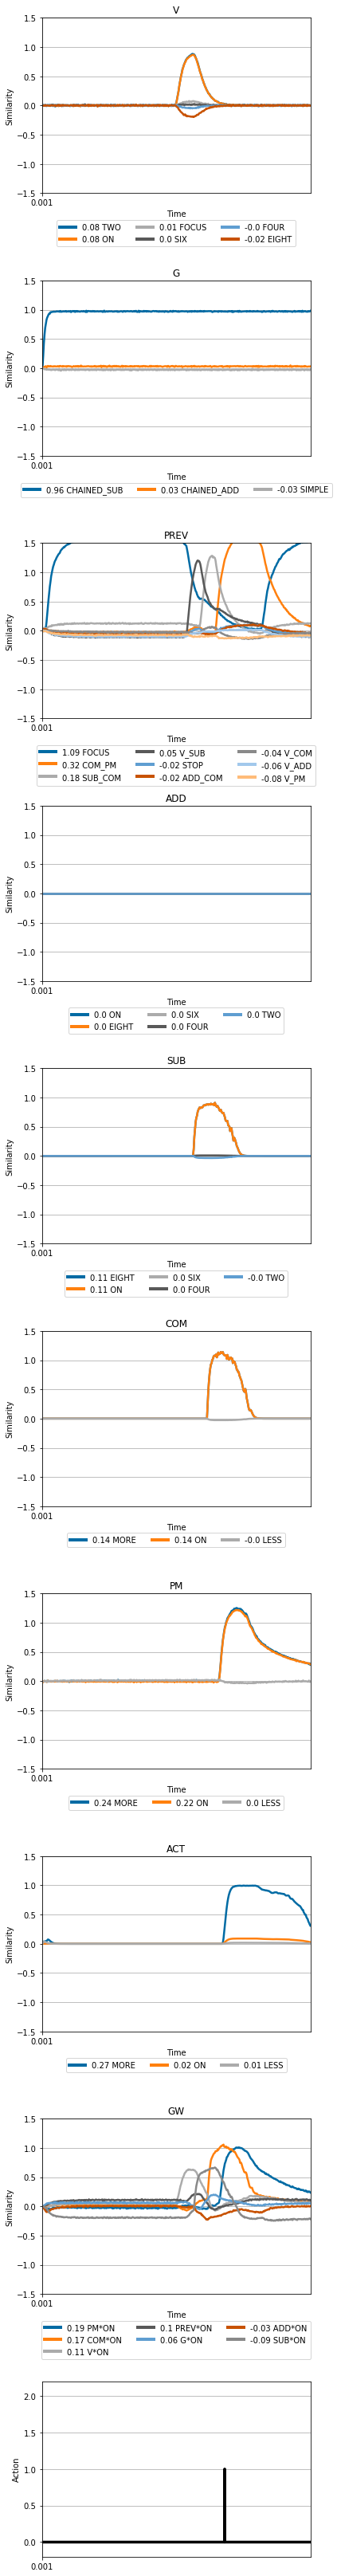

In [6]:
if True:
    
    def plot_similarities(t_range, data, vocab, keys=False, autoscale=False, title='Similarity', sort_legend=True, permutation=None, subplot_nrows=0, subplot_ncols=0, subplot_i = 1):

        if not keys:
            keys = list(vocab.keys())

        if subplot_nrows * subplot_ncols > 0:
            plt.subplot(subplot_nrows,subplot_ncols,subplot_i)

        if permutation is None:
            permutation = range(vocab.dimensions)
        vectors = np.array([vocab.parse(p).v @ np.identity(vocab.dimensions)[permutation] for p in keys])
        mean_activation = spa.similarity(data, vectors).mean(axis=0)
        sort_idx = np.argsort(mean_activation)[::-1]    

        ymin, ymax = -1.5, 1.5
        plt.ylim(ymin, ymax)
        plt.autoscale(autoscale, axis='y')
        plt.grid(True)
        plt.plot(t_range, spa.similarity(data, vectors[sort_idx]), linewidth=2.5)
        plt.title(title)
        plt.xlabel("Time")
        plt.ylabel("Similarity")
        plt.xlim(left=t_range[0], right=t_range[-1])
        plt.xticks(np.arange(t_range[0], t_range[-1], xp.trial_length))
        leg = plt.legend([str(round(mean_activation[sort_idx][i],2))+' '+k for i,k in enumerate(np.array(keys)[sort_idx])], loc='upper center',
                   bbox_to_anchor=(0.5, -0.13), ncol=3)
        
        # set the linewidth of each legend object
        for legobj in leg.legendHandles:
            legobj.set_linewidth(4.0)
            
        if subplot_nrows * subplot_ncols == 0:
            plt.show()

        return subplot_i + 1



    subplot_nrows=10
    subplot_ncols=1
    plt.figure(figsize=(6*subplot_ncols,4.5*subplot_nrows))
    
    def trial_t(trial_number):
        return trial_number*xp.trial_length
    
    start = trial_t(0)
    end = trial_t(1)
    skip = 5
    trange = sim.trange()
    selected_idx = np.where(np.logical_and(trange > start, trange < end))
    trange = trange[selected_idx][::skip]


    subplot_i=plot_similarities(trange, sim.data[p_V][selected_idx][::skip], vocab_memory, keys=['TWO','FOUR','SIX','EIGHT', 'ON','FOCUS'], title='V', subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_G][selected_idx][::skip], vocab_memory, keys=['SIMPLE','CHAINED_SUB','CHAINED_ADD'], title='G', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_PREV][selected_idx][::skip], prim_vocab, title='PREV', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_ADD][selected_idx][::skip], vocab_memory, keys=['TWO','FOUR','SIX','EIGHT','ON'], title='ADD', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_SUB][selected_idx][::skip], vocab_memory, keys=['TWO','FOUR','SIX','EIGHT','ON'], title='SUB', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_COM][selected_idx][::skip], vocab_memory, keys=['MORE','LESS','ON'], title='COM', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_PM][selected_idx][::skip], vocab_memory, keys=['MORE','LESS','ON'], title='PM', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_ACT][selected_idx][::skip], vocab_memory, keys=['MORE','LESS','ON'], title='ACT', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_GW][selected_idx][::skip], vocab_memory, keys=[p+"*ON" for p in ["G", "V", "PREV", "PM", "ADD", "SUB", "COM"]], title='GW', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)

    trange = sim.trange()[selected_idx]
    plt.subplot(subplot_nrows,subplot_ncols,subplot_i)
    plt.plot(trange, sim.data[p_BTN][selected_idx], color='black', linewidth=3.5)
    plt.xlim(left=trange[0], right=trange[-1])
    plt.xticks(np.arange(trange[0], trange[-1], xp.trial_length))
    plt.ylim(-.2,2.2)
    plt.ylabel("Action")
    plt.grid(True)
    
    plt.tight_layout()

    plt.show()
    
    


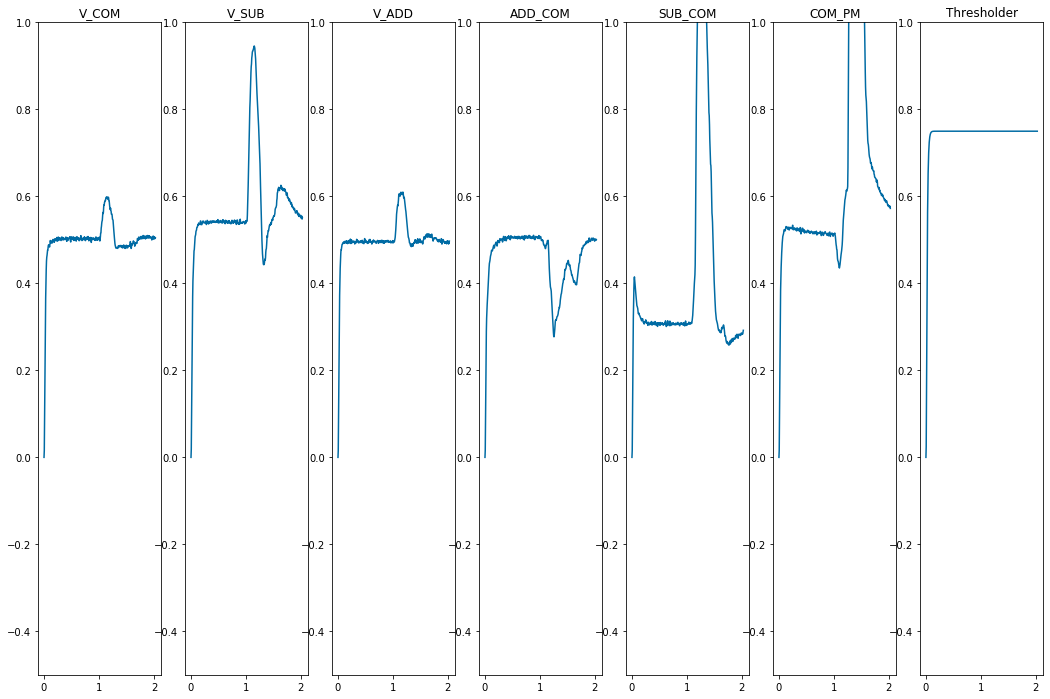

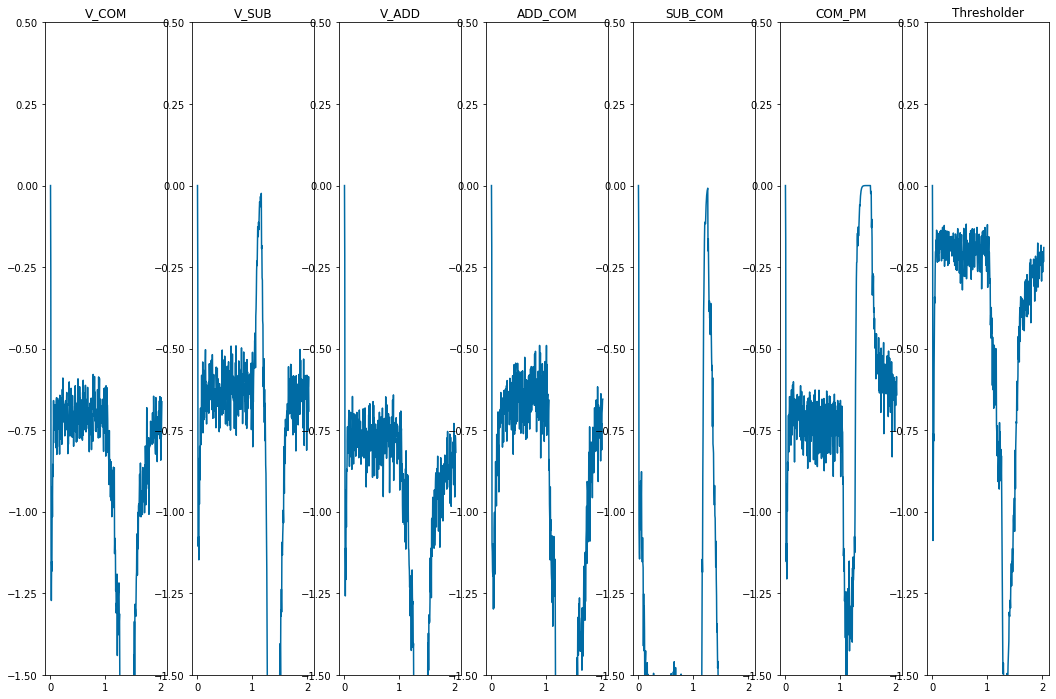

In [7]:
plt.figure(figsize=(18,12))
for i in range(bg_thalamus.bg.input.size_out):
    plt.subplot(1,bg_thalamus.bg.input.size_out,i+1)
    plt.plot(sim.trange()[selected_idx][::skip], sim.data[p_bg_in][:,i][selected_idx][::skip])
    plt.title(action_labels[i])
    plt.ylim(-.5,1)

plt.show()

plt.figure(figsize=(18,12))
for i in range(bg_thalamus.bg.input.size_out):
    plt.subplot(1,bg_thalamus.bg.input.size_out,i+1)
    plt.plot(sim.trange()[selected_idx][::skip], sim.data[p_bg_out][:,i][selected_idx][::skip])
    plt.title(action_labels[i])
    plt.ylim(-1.5,.5)

plt.show()

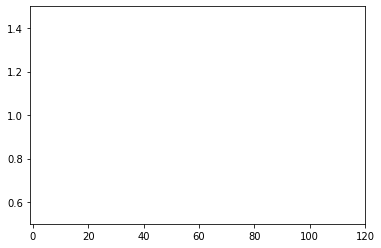

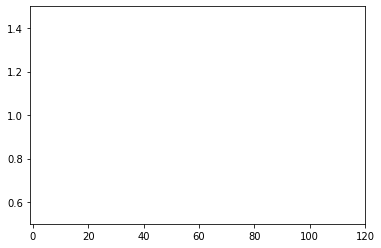

Total score: 120/120
Score after learning: 120/120


In [8]:
key_to_int = {'TWO':2, 'FOUR':4, 'SIX':6, 'EIGHT':8}
COMresult_to_action = {True:'MORE', False:'LESS'}

def get_expected_action(trial):
    N = key_to_int[trial.stimulus] 
    #print(trial.operation, trial.stimulus)
    if trial.operation == 'CHAINED_ADD':
        N += 2
    elif trial.operation == 'CHAINED_SUB':
        N -= 2
    if N > 8:
        N = 2
    elif N < 2:
        N = 8
    expected_action = 1 + int(not N > 5)
    return expected_action

correct = []

t = 0
while t<T-.01:
    
    # Find the expected action
    t += xp.trial_length
    expected_action = get_expected_action(xp(t)[0])
    action_idx = (np.where(np.logical_and(sim.trange() < t, sim.trange() > t-xp.trial_length))[0],)
    model_action = sim.data[p_BTN][action_idx]
    if np.count_nonzero(model_action) > 1:
        print("ERROR: more than one action")
    model_action = model_action.sum()
    correct += [model_action==expected_action]



correct = np.array(correct, dtype=bool)
test_correct = correct[-number_of_non_learning_trials:]

plt.eventplot(np.where(np.logical_not(correct)))
plt.ylim(0.5,1.5)
plt.xlim(-1,len(correct))
plt.show()

plt.eventplot(np.where(np.logical_not(test_correct)))
plt.ylim(0.5,1.5)
plt.xlim(-1,len(test_correct))
plt.show()


print('Total score: '+str(correct.sum())+'/'+str(number_of_total_trials))
print('Score after learning: '+str(test_correct.sum())+'/'+str(number_of_non_learning_trials))
